<a href="https://colab.research.google.com/github/gloriapintado/Cervical-Cancer-Prediction/blob/main/Cervical_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cervical Prediction by Images Classification

## Overview

Females in Africa have a notable prevalence of cervical cancer cases, according to the "Accurate Diagnosis Health" clinic. They want to set up neighborhood screening facilities throughout Africa in order to improve their clinic's standing and address this important health issue. The identification and referral process for possible instances of cervical cancer will be improved at these centers by using an automated tool for preliminary analysis. The main goal is to guarantee quicker and more precise identification, which will allow for improved cervical cancer case evaluation and treatment.

# Data Source

I found a dataset in Kaggle named “Multi Cancer Dataset” which contains many images of different types of cancers such as Acute Lymphoblastic Leukemia, Brain Cancer, Breast Cancer, Cervical Cancer, Kidney Cancer, Lung, Colon Cancer, Lymphoma, and Oral Cancer. However, I will be focusing on Cervical Cancer since “AD Health” main goal is to determine by screening diagnosis.

This 25,000-image dataset on cervical cancer includes five subsets, each containing 5000 images and labeled after one of the five classifications of cervical cancer. Making this a multiclass classification.

### Types of Cervical Cancer

- 0: Dyskeratotic
- 1: Koilocytotic
- 2: Metaplastic
- 3: Parabasal
- 4: Superficial-Intermediat

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import random
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from keras import regularizers
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

# Load Dataset

In [3]:
directory_path = '/content/drive/MyDrive/Cervical Cancer/'
def count_images_in_directory(directory):
    if not os.path.exists(directory):
        print("Directory does not exist")
        return

    if not os.path.isdir(directory):
        print("Provided path is not a directory")
        return

    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            file_count = sum([len(files) for _, _, files in os.walk(class_path)])
            print(f"Total images in {class_folder} directory: {file_count}")

count_images_in_directory(directory_path)

Total images in cervix_dyk directory: 5000
Total images in cervix_koc directory: 5000
Total images in cervix_mep directory: 5000
Total images in cervix_pab directory: 5000
Total images in cervix_sfi directory: 5000


In [4]:
image_directory = '/content/drive/MyDrive/Cervical Cancer/'
SIZE = 150

dataset = []
label = []

# For each class, load images and assign labels
class_folders = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

for class_folder in class_folders:
    images = os.listdir(image_directory + class_folder + '/')
    for image_name in images:
        if image_name.split('.')[1] == 'jpg':
            image = cv2.imread(image_directory + class_folder + '/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))

            label.append(class_folders.index(class_folder))

dataset = np.array(dataset)
label = np.array(label)

In [5]:
dataset.shape

(25000, 150, 150, 3)

In [6]:
label.shape

(25000,)

# Displaying an Image from each Class

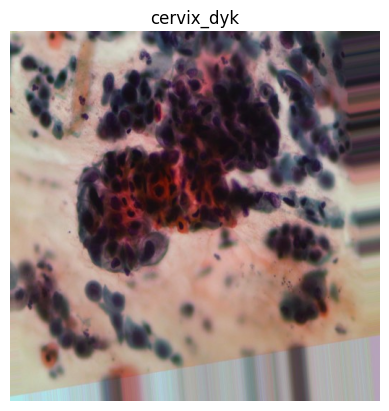

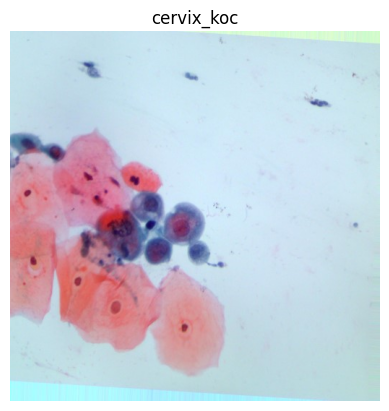

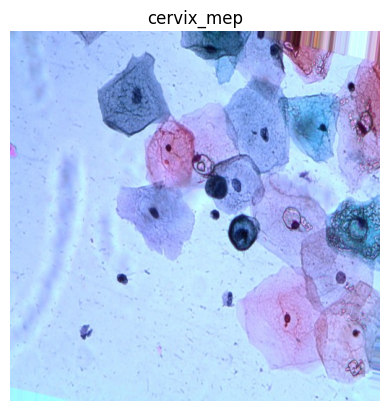

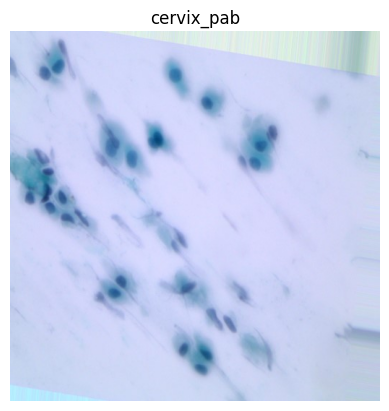

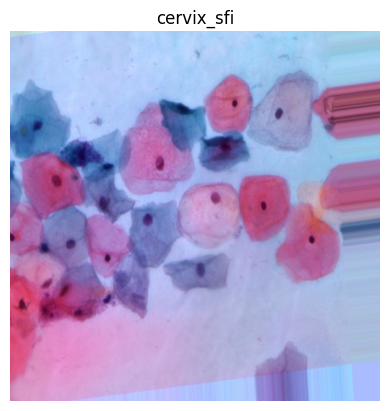

In [7]:
for class_folder in class_folders:
    images = os.listdir(image_directory + class_folder + '/')

    image_name = random.choice([img for img in images if img.endswith('.jpg')])
    image_path = image_directory + class_folder + '/' + image_name

    # Display the randomly image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(class_folder)
    plt.axis('off')
    plt.show()

# Splitting the Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 42)

In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20000, 150, 150, 3)
X_test shape: (5000, 150, 150, 3)
y_train shape: (20000,)
y_test shape: (5000,)


# **Base model CNN**

In [10]:
base_modelCC = Sequential()

# Normalize
base_modelCC.add(Lambda(lambda x: x / 255.0, input_shape=(150, 150, 3)))

# Convolutional layers
base_modelCC.add(Conv2D(64, (3, 3), activation='relu'))
base_modelCC.add(MaxPooling2D((2, 2)))

# Flatten the output
base_modelCC.add(Flatten())

base_modelCC.add(Dense(64, activation='relu'))
base_modelCC.add(Dense(5, activation='softmax'))

In [11]:
base_modelCC.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 350464)            0         
                                                                 
 dense (Dense)               (None, 64)                22429760  
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                        

In [12]:
base_modelCC.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [13]:
history_base_modelCC = base_modelCC.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_callback])

Epoch 1/20
625/625 [==============================] - 16s 9ms/step - loss: 0.9442 - accuracy: 0.7480 - val_loss: 0.3794 - val_accuracy: 0.8542
Epoch 2/20
625/625 [==============================] - 5s 8ms/step - loss: 0.2850 - accuracy: 0.9011 - val_loss: 0.3027 - val_accuracy: 0.8912
Epoch 3/20
625/625 [==============================] - 5s 8ms/step - loss: 0.1462 - accuracy: 0.9514 - val_loss: 0.2088 - val_accuracy: 0.9286
Epoch 4/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0827 - accuracy: 0.9743 - val_loss: 0.2735 - val_accuracy: 0.9092
Epoch 5/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0924 - accuracy: 0.9707 - val_loss: 0.2532 - val_accuracy: 0.9150
Epoch 6/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0571 - accuracy: 0.9828 - val_loss: 0.2539 - val_accuracy: 0.9148
Epoch 7/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0342 - accuracy: 0.9909 - val_loss: 0.2307 - val_accuracy: 0.9316
Epoch

# Accuracy and Loss of Base Model

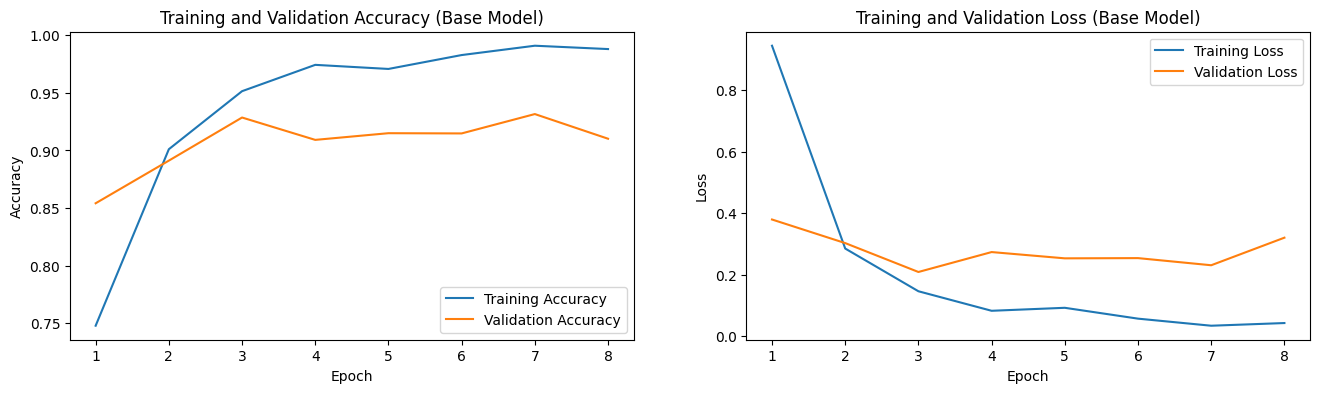

In [14]:
acc = history_base_modelCC.history['accuracy']
val_acc = history_base_modelCC.history['val_accuracy']
loss = history_base_modelCC.history['loss']
val_loss = history_base_modelCC.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Base Model)')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Base Model)')
plt.show()

In [15]:
evaluation = base_modelCC.evaluate(X_test, y_test)

157/157 [==============================] - 1s 3ms/step - loss: 0.3203 - accuracy: 0.9102


In [16]:
evaluation

[0.32030680775642395, 0.9101999998092651]

In [17]:
predictions = base_modelCC.predict(X_test)

157/157 [==============================] - 0s 2ms/step


In [18]:
y_pred = np.argmax(predictions, axis=1)

# Confusion Matrix Base Model

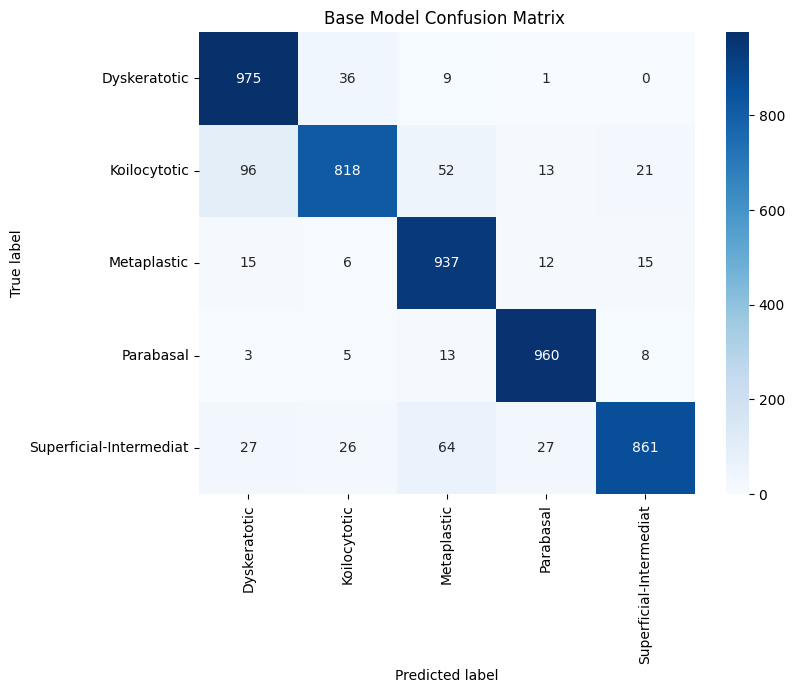

In [19]:
class_names = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-Intermediat']

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Base Model Confusion Matrix ')
plt.show()

In [20]:
print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

           Dyskeratotic       0.87      0.95      0.91      1021
           Koilocytotic       0.92      0.82      0.87      1000
            Metaplastic       0.87      0.95      0.91       985
              Parabasal       0.95      0.97      0.96       989
Superficial-Intermediat       0.95      0.86      0.90      1005

               accuracy                           0.91      5000
              macro avg       0.91      0.91      0.91      5000
           weighted avg       0.91      0.91      0.91      5000



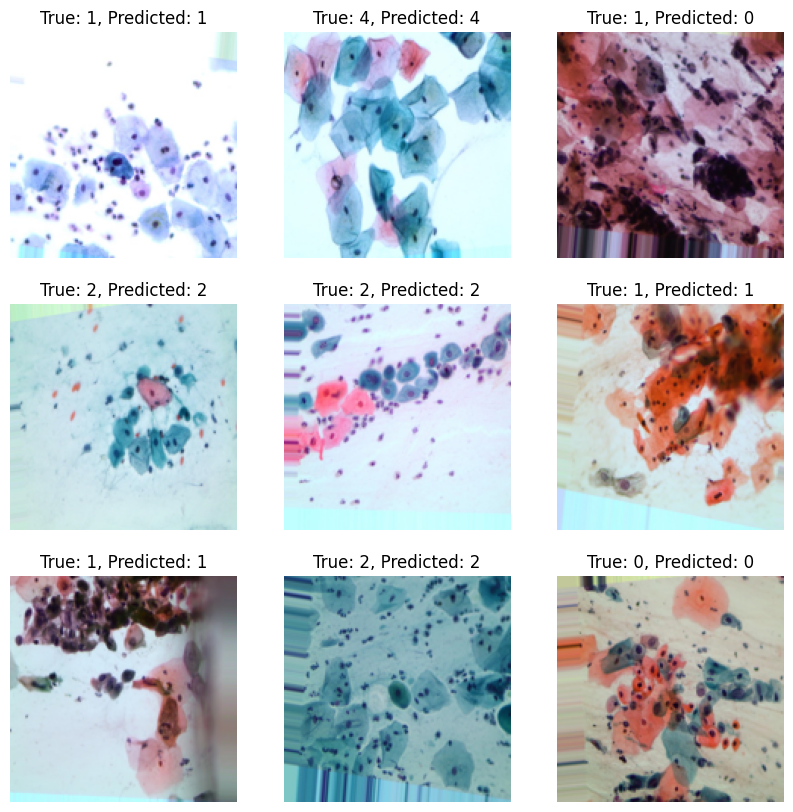

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
    # Display the image in RGB format
    image_rgb = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_rgb)
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred[i]}")
    plt.axis('off')

plt.show()

# **Model 2 CNN**

In [39]:
model2CC = Sequential()
# Normalize the input image data
model2CC.add(Lambda(lambda x: x / 255.0, input_shape=(150, 150, 3)))
model2CC.add(Conv2D(32, (3, 3), activation='relu'))
model2CC.add(MaxPooling2D((2, 2)))
model2CC.add(Conv2D(64, (3, 3), activation='relu'))
model2CC.add(MaxPooling2D((2, 2)))
model2CC.add(Conv2D(128, (3, 3), activation='relu'))
# Flatten the output and add dropout and L2 regularization
model2CC.add(Flatten())
model2CC.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2CC.add(Dropout(0.2))
model2CC.add(Dense(5, activation='softmax'))

In [40]:
model2CC.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 150, 150, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)      

In [41]:
model2CC.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [42]:
history_model2CC = model2CC.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_callback])

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 1.0579 - accuracy: 0.6848 - val_loss: 0.8359 - val_accuracy: 0.7940
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.7540 - accuracy: 0.7936 - val_loss: 0.5854 - val_accuracy: 0.8592
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.6448 - accuracy: 0.8414 - val_loss: 0.6102 - val_accuracy: 0.8584
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5784 - accuracy: 0.8645 - val_loss: 0.4715 - val_accuracy: 0.9056
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5543 - accuracy: 0.8844 - val_loss: 0.4762 - val_accuracy: 0.9178
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5235 - accuracy: 0.9014 - val_loss: 0.5637 - val_accuracy: 0.9006
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4913 - accuracy: 0.9170 - val_loss: 0.4828 - val_accuracy: 0.9274
Epoch

In [43]:
evaluation2 = model2CC.evaluate(X_test, y_test)

157/157 [==============================] - 1s 4ms/step - loss: 0.5030 - accuracy: 0.9296


In [44]:
predictions2 = model2CC.predict(X_test)

157/157 [==============================] - 1s 3ms/step


In [45]:
y_pred2 = np.argmax(predictions2, axis=1)

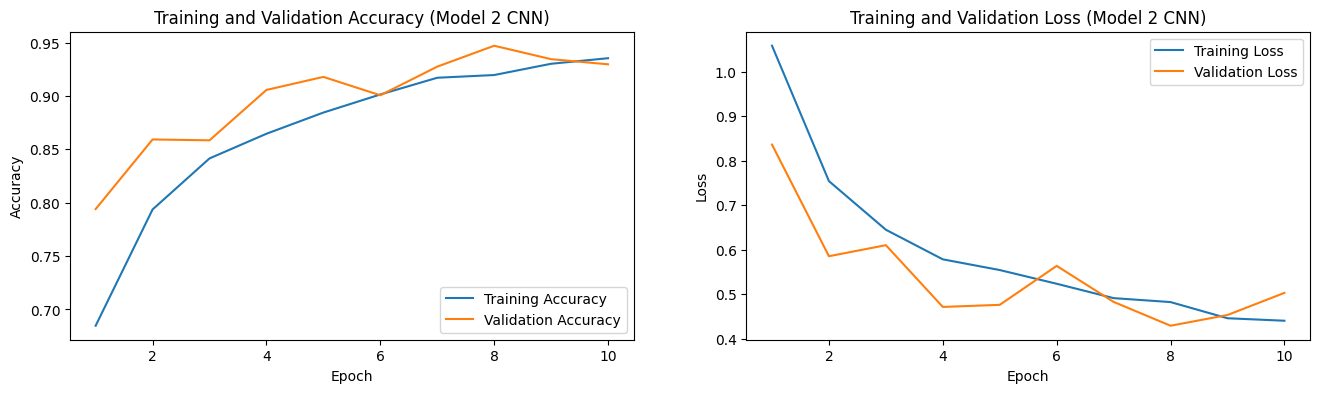

In [46]:
acc = history_model2CC.history['accuracy']
val_acc = history_model2CC.history['val_accuracy']
loss = history_model2CC.history['loss']
val_loss = history_model2CC.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model 2 CNN)')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 2 CNN)')
plt.show()

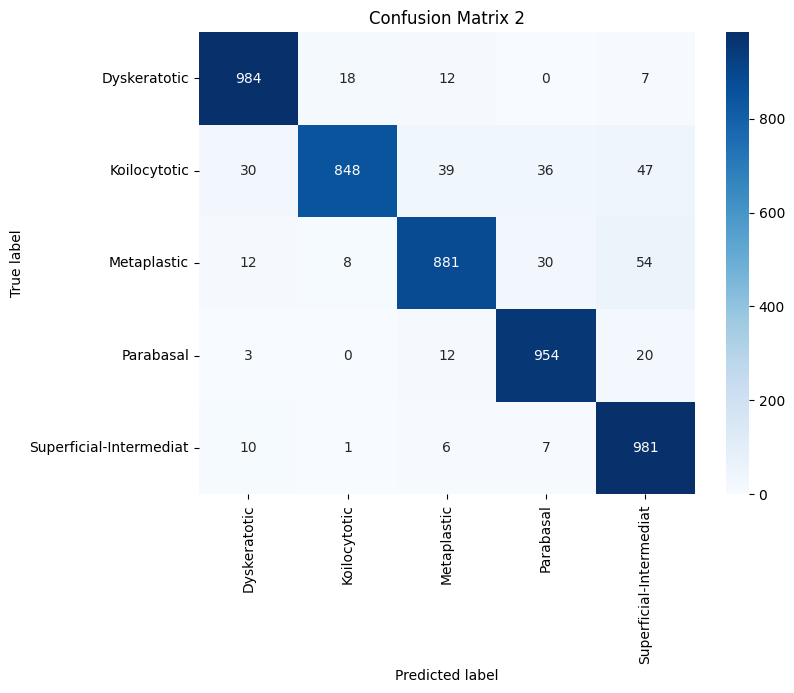

In [47]:
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix 2')
plt.show()

In [48]:
print(classification_report(y_test, y_pred2, target_names=class_names))

                         precision    recall  f1-score   support

           Dyskeratotic       0.95      0.96      0.96      1021
           Koilocytotic       0.97      0.85      0.90      1000
            Metaplastic       0.93      0.89      0.91       985
              Parabasal       0.93      0.96      0.95       989
Superficial-Intermediat       0.88      0.98      0.93      1005

               accuracy                           0.93      5000
              macro avg       0.93      0.93      0.93      5000
           weighted avg       0.93      0.93      0.93      5000



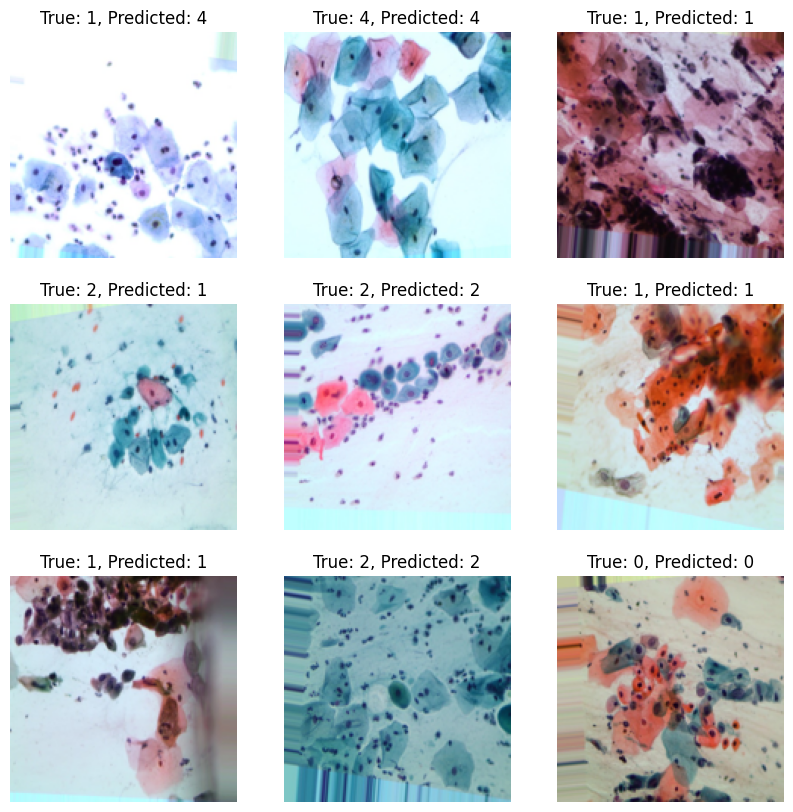

In [50]:
plt.figure(figsize=(10, 10))
for i in range(9):
    # Display the image in RGB format
    image_rgb = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_rgb)
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred2[i]}")
    plt.axis('off')

plt.show()

# 3 Model CNN

In [58]:
model3 = Sequential()
# Normalize the input image data
model3.add(Lambda(lambda x: x / 255.0, input_shape=(150, 150, 3)))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
# Flatten the output and add dropout and L2 regularization
model3.add(Flatten())
model3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(5, activation='softmax'))

In [59]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 150, 150, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 34, 34, 64)       

In [60]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [61]:
history_model3 = model3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_callback])

Epoch 1/10
625/625 [==============================] - 8s 10ms/step - loss: 0.9308 - accuracy: 0.6647 - val_loss: 0.5125 - val_accuracy: 0.8498
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4483 - accuracy: 0.8636 - val_loss: 0.3476 - val_accuracy: 0.8934
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3215 - accuracy: 0.9117 - val_loss: 0.2355 - val_accuracy: 0.9430
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2486 - accuracy: 0.9390 - val_loss: 0.2354 - val_accuracy: 0.9408
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1984 - accuracy: 0.9566 - val_loss: 0.1599 - val_accuracy: 0.9704
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1794 - accuracy: 0.9638 - val_loss: 0.1793 - val_accuracy: 0.9530
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1515 - accuracy: 0.9712 - val_loss: 0.0978 - val_accuracy: 0.9874
Epoch

### Saving Best Model

In [71]:
model_save_name = 'best_model3.h5'
model3.save(model_save_name)
model_save_path = model_save_name
drive_path = "/content/drive/MyDrive/Cervical_Cancer_Models/models/"
!mkdir -p "$drive_path"
!cp $model_save_path "$drive_path"

In [62]:
evaluation3 = model3.evaluate(X_test, y_test)

157/157 [==============================] - 1s 4ms/step - loss: 0.1193 - accuracy: 0.9748


In [63]:
predictions3 = model3.predict(X_test)

157/157 [==============================] - 0s 3ms/step


In [64]:
y_pred3 = np.argmax(predictions3, axis=1)

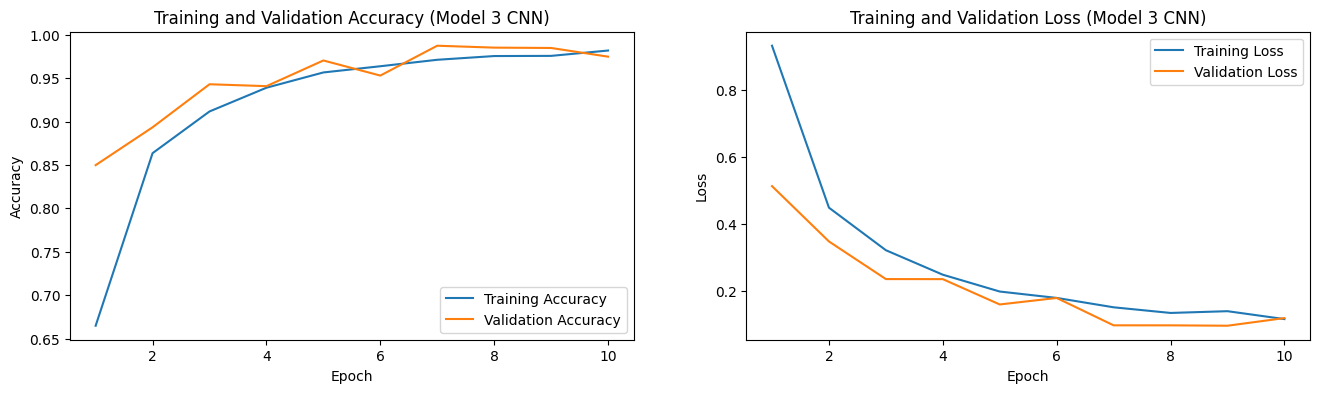

In [65]:
acc = history_model3.history['accuracy']
val_acc = history_model3.history['val_accuracy']
loss = history_model3.history['loss']
val_loss = history_model3.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model 3 CNN)')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 3 CNN)')
plt.show()

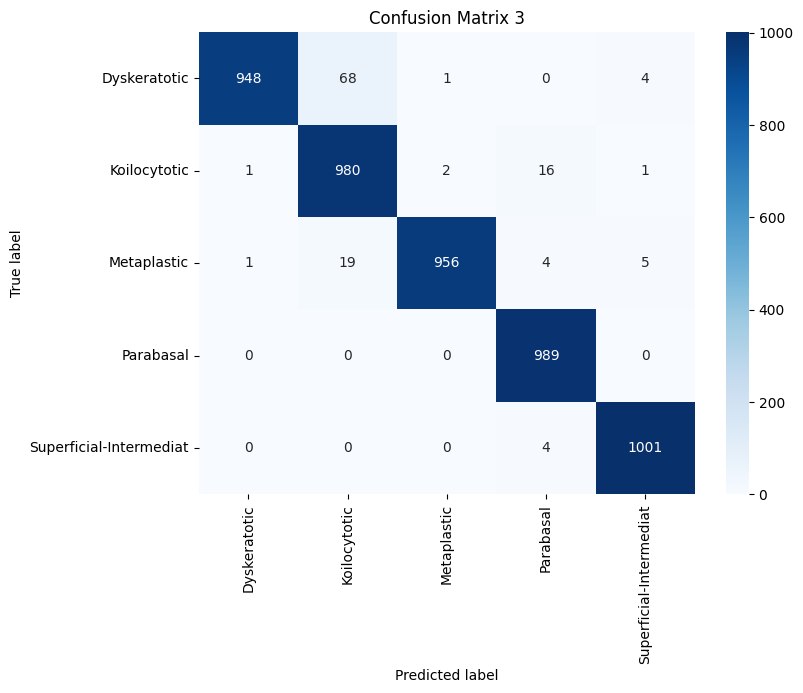

In [66]:
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred3)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix 3')
plt.show()

In [67]:
print(classification_report(y_test, y_pred3, target_names=class_names))

                         precision    recall  f1-score   support

           Dyskeratotic       1.00      0.93      0.96      1021
           Koilocytotic       0.92      0.98      0.95      1000
            Metaplastic       1.00      0.97      0.98       985
              Parabasal       0.98      1.00      0.99       989
Superficial-Intermediat       0.99      1.00      0.99      1005

               accuracy                           0.97      5000
              macro avg       0.98      0.98      0.97      5000
           weighted avg       0.98      0.97      0.97      5000



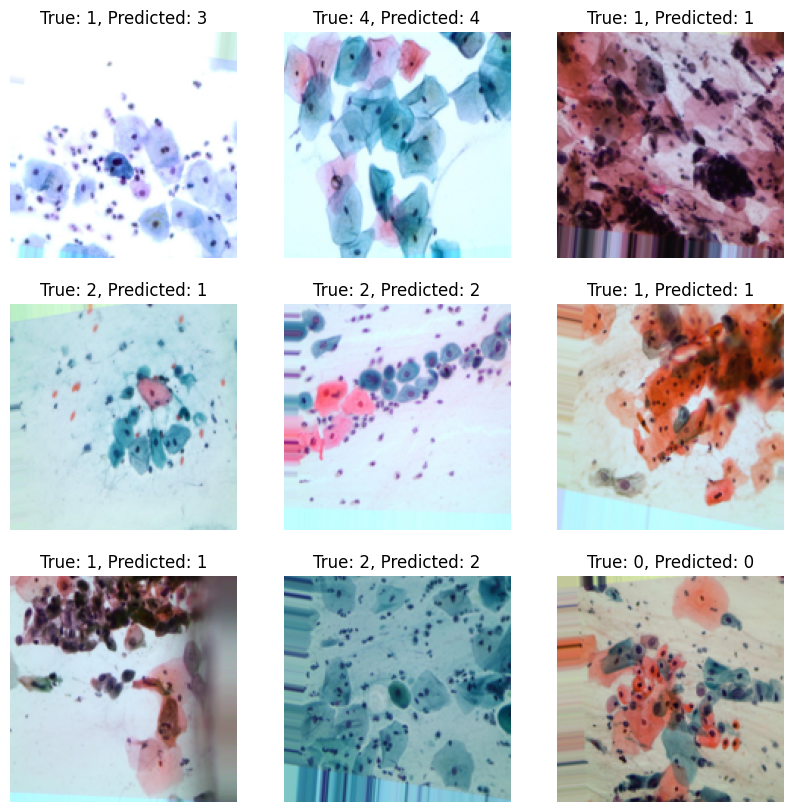

In [69]:
plt.figure(figsize=(10, 10))
for i in range(9):
    # Display the image in RGB format
    image_rgb = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_rgb)
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred3[i]}")
    plt.axis('off')

plt.show()

# Model 4 CNN In process...

In [50]:
model4 = Sequential()
# Normalize the input image data
model4.add(Lambda(lambda x: x / 255.0, input_shape=(200, 200, 3)))
model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Conv2D(128, (3, 3), activation='relu'))
# Flatten the output and add dropout and L2 regularization
model4.add(Flatten())
model4.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model4.add(Dropout(0.2))
model4.add(Dense(5, activation='softmax'))

In [52]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 200, 200, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 128)      